# Clasificación de Frames con Embeddings Pregenerados

## Objetivos:
1. Cargar dataset `df_frames_openai_labeled_v3.csv` con etiquetas de OpenAI
2. Cargar embeddings pregenerados de `features_resnet50/` del pipeline de extracción de keyframes
3. Entrenar cabeza de predicción sobre los embeddings
4. Evaluar desempeño del modelo
5. Unir modelo preentrenado (ResNet50) con cabeza de predicción entrenada
6. Probar inferencias con frames nuevos (no embeddings pregenerados)


In [2]:
#pip install autogluon

In [4]:
from pathlib import Path
import sys
# Configuración de paths
project_root = Path("/Users/andrestrepo/Documents/repos_personal/proyecto-vision-computador")
sys.path.insert(0, str(project_root))
sys.path.insert(0, str(project_root / "src"))

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter, defaultdict
import cv2
import pickle

from autogluon.tabular import TabularPredictor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Importar FeatureExtractor para cargar embeddings
from src.app.utils.feature_extractor import FeatureExtractor

# Configurar matplotlib para mejor visualización
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")


/Users/andrestrepo/Documents/repos_personal/proyecto-vision-computador/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Cargar dataset df_frames_openai_labeled_v3.csv y exploración

In [6]:
# Configuración de paths
project_root = Path("/Users/andrestrepo/Documents/repos_personal/proyecto-vision-computador")
dataset_path = project_root / "src" / "notebooks" / "datasets" / "df_frames_openai_labeled_v3.csv"
features_dir = project_root / "src" / "notebooks" / "features_resnet50"

print(f"Dataset path: {dataset_path}")
print(f"Features directory: {features_dir}")

Dataset path: /Users/andrestrepo/Documents/repos_personal/proyecto-vision-computador/src/notebooks/datasets/df_frames_openai_labeled_v3.csv
Features directory: /Users/andrestrepo/Documents/repos_personal/proyecto-vision-computador/src/notebooks/features_resnet50


In [7]:
# Cargar dataset df_frames_openai_labeled_v3.csv
print("🔄 Cargando dataset df_frames_openai_labeled_v3.csv...")

if not dataset_path.exists():
    raise FileNotFoundError(f"Dataset no encontrado: {dataset_path}")

df_dataset = pd.read_csv(dataset_path)
print(f"✅ Dataset cargado: {len(df_dataset):,} frames")

# Explorar estructura del dataset
print(f"\n📊 Estructura del dataset:")
print(f"   Columnas: {df_dataset.columns.tolist()}")
print(f"   Shape: {df_dataset.shape}")

# Filtrar frames válidos (sin errores, con etiquetas válidas)
print(f"\n🔍 Filtrando frames válidos...")
df_valid = df_dataset[
    (df_dataset['openai_error'].isna() | (df_dataset['openai_error'] == '')) &
    (df_dataset['openai_category_code'].notna()) &
    (df_dataset['frame_path'].notna())
].copy()

print(f"   Frames originales: {len(df_dataset):,}")
print(f"   Frames válidos: {len(df_valid):,}")
print(f"   Frames descartados: {len(df_dataset) - len(df_valid):,} ({(len(df_dataset) - len(df_valid))/len(df_dataset)*100:.1f}%)")

# Análisis de distribución de clases
print(f"\n📊 Distribución de clases (openai_category_code):")
class_distribution = df_valid['openai_category_code'].value_counts()
print(f"   Número de clases únicas: {len(class_distribution)}")
print(f"   Clases principales:")
for i, (class_name, count) in enumerate(class_distribution.items(), 1):
    percentage = (count / len(df_valid)) * 100
    print(f"     {i:2d}. {class_name:<20} {count:>6} frames ({percentage:5.1f}%)")

# Usar el dataset filtrado
df_info = df_valid

🔄 Cargando dataset df_frames_openai_labeled_v3.csv...
✅ Dataset cargado: 10,000 frames

📊 Estructura del dataset:
   Columnas: ['video_id', 'channel', 'video_date', 'video_filename', 'duration', 'frame_path', 'n_frames_original', 'n_frames_filtrado', 'reduction_percentage', 'clip_category_idx', 'clip_category_code', 'clip_category_text', 'clip_score', 'openai_category_code', 'openai_category_text', 'openai_raw_response', 'openai_error']
   Shape: (10000, 17)

🔍 Filtrando frames válidos...
   Frames originales: 10,000
   Frames válidos: 10,000
   Frames descartados: 0 (0.0%)

📊 Distribución de clases (openai_category_code):
   Número de clases únicas: 11
   Clases principales:
      1. person                 6855 frames ( 68.5%)
      2. candlestick             847 frames (  8.5%)
      3. text                    615 frames (  6.2%)
      4. screenshot              488 frames (  4.9%)
      5. table                   421 frames (  4.2%)
      6. logo                    370 frames (  3.7

In [9]:
# Mostrar muestra del dataset
print("\n📋 Muestra del dataset:")
df_info.head()


📋 Muestra del dataset:


,video_id,channel,video_date,video_filename,duration,frame_path,n_frames_original,n_frames_filtrado,reduction_percentage,clip_category_idx,clip_category_code,clip_category_text,clip_score,openai_category_code,openai_category_text,openai_raw_response,openai_error
0,9KqNLKKB1fw,Bolsas hoy ｜ Esteban Pérez Inversor,20240528,9KqNLKKB1fw_20240528.mp4,972.766667,frames/Bolsas hoy ｜ Esteban Pérez Inversor/9Kq...,487,216,55.646817,3,candlestick,"a candlestick chart, Japanese candlestick char...",0.271621,candlestick,"a candlestick chart, Japanese candlestick char...",candlestick,NaN
1,uu-0Ha2e970,Bitcoin hoy ｜ Esteban Perez Trader,20240919,uu-0Ha2e970_20240919.mp4,1569.733333,frames/Bitcoin hoy ｜ Esteban Perez Trader/uu-0...,785,310,60.509554,0,person,"a person speaking, presenting, or talking on c...",0.255480,person,"a person speaking, presenting, or talking on c...",person,NaN
2,_nQhNnKkpI0,ARENA ALFA,20200810,_nQhNnKkpI0_20200810.mp4,1168.300000,frames/ARENA ALFA /_nQhNnKkpI0_20200810_frame2...,584,67,88.527397,10,other,other type of visual content not matching the ...,0.218082,person,"a person speaking, presenting, or talking on c...",person,NaN
3,_XzhwYzznDM,Bitcoin hoy ｜ Esteban Perez Trader,20230418,_XzhwYzznDM_20230418.mp4,989.466667,frames/Bitcoin hoy ｜ Esteban Perez Trader/_Xzh...,495,223,54.949495,9,screenshot,"a computer screen, application interface, or s...",0.252751,screenshot,"a computer screen, application interface, or s...",screenshot,NaN
4,vYBiV9EAJM0,Bitcoin hoy ｜ Esteban Perez Trader,20250219,vYBiV9EAJM0_20250219.mp4,1573.000000,frames/Bitcoin hoy ｜ Esteban Perez Trader/vYBi...,787,506,35.705210,0,person,"a person speaking, presenting, or talking on c...",0.256490,person,"a person speaking, presenting, or talking on c...",person,NaN


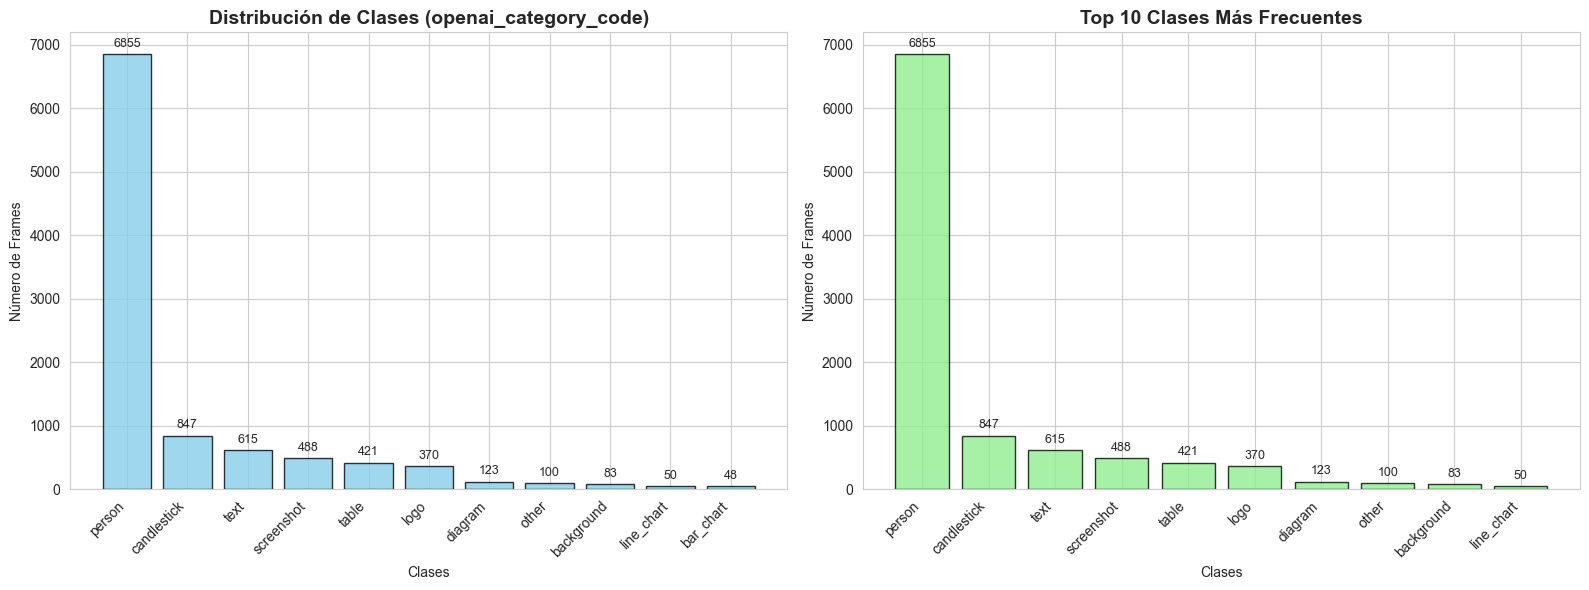


📊 RESUMEN:
  • Total de frames: 10,000
  • Número de clases: 11
  • Clase más frecuente: person (6,855 frames)
  • Clase menos frecuente: bar_chart (48 frames)


In [11]:
# Visualización de distribución de clases
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Distribución de clases principales
class_distribution = df_info['openai_category_code'].value_counts()
axes[0].bar(range(len(class_distribution)), class_distribution.values, 
           color='skyblue', edgecolor='black', alpha=0.8)
axes[0].set_title('Distribución de Clases (openai_category_code)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Clases')
axes[0].set_ylabel('Número de Frames')
axes[0].set_xticks(range(len(class_distribution)))
axes[0].set_xticklabels(class_distribution.index, rotation=45, ha='right')
for i, v in enumerate(class_distribution.values):
    axes[0].text(i, v + max(class_distribution.values)*0.01, str(v), 
                ha='center', va='bottom', fontsize=9)

# 2. Top 10 clases más frecuentes
top_10_classes = class_distribution.head(10)
axes[1].bar(range(len(top_10_classes)), top_10_classes.values, 
          color='lightgreen', edgecolor='black', alpha=0.8)
axes[1].set_title('Top 10 Clases Más Frecuentes', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Clases')
axes[1].set_ylabel('Número de Frames')
axes[1].set_xticks(range(len(top_10_classes)))
axes[1].set_xticklabels(top_10_classes.index, rotation=45, ha='right')
for i, v in enumerate(top_10_classes.values):
    axes[1].text(i, v + max(top_10_classes.values)*0.01, str(v), 
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\n📊 RESUMEN:")
print(f"  • Total de frames: {len(df_info):,}")
print(f"  • Número de clases: {len(class_distribution)}")
print(f"  • Clase más frecuente: {class_distribution.index[0]} ({class_distribution.iloc[0]:,} frames)")
print(f"  • Clase menos frecuente: {class_distribution.index[-1]} ({class_distribution.iloc[-1]:,} frames)")


# 2. Cargar embeddings pregenerados desde features_resnet50/


In [12]:
# Configuración del modelo de embeddings (debe coincidir con el usado en el pipeline)
MODEL_NAME = 'resnet50'  # Debe ser el mismo que se usó en keyframe_extraction_pipeline.ipynb

if not features_dir.exists():
    raise FileNotFoundError(
        f"Directorio de features no encontrado: {features_dir}\n"
        f"Ejecuta primero el notebook 'keyframe_extraction_pipeline.ipynb' para generar los embeddings."
    )

print(f"✅ Directorio de features encontrado: {features_dir}")
print(f"   Modelo: {MODEL_NAME}")

# Inicializar feature extractor para cargar embeddings
device = 'cuda' if torch.cuda.is_available() else 'cpu'
feature_extractor = FeatureExtractor(model_name=MODEL_NAME, device=device, batch_size=32)

print(f"\n🔧 Feature extractor inicializado: {MODEL_NAME} en {device}")
print(f"   Dimensión de features: {feature_extractor.feature_dim}")


✅ Directorio de features encontrado: /Users/andrestrepo/Documents/repos_personal/proyecto-vision-computador/src/notebooks/features_resnet50
   Modelo: resnet50
Cargando RESNET50 en cpu...
Modelo RESNET50 cargado exitosamente
Dimensión de features: 2048

🔧 Feature extractor inicializado: resnet50 en cpu
   Dimensión de features: 2048


In [13]:
# Cargar embeddings para cada frame
# Los embeddings están guardados por video, así que los cargamos y mapeamos a frames
print(f"🔄 Cargando embeddings para {len(df_info):,} frames...")

# Agrupar por video para cargar eficientemente
embeddings_dict = {}  # frame_path -> embedding
missing_embeddings = []

# Obtener lista única de videos
video_ids = df_info['video_id'].unique()
print(f"   Videos únicos: {len(video_ids)}")

# Cargar embeddings por video
for video_id in tqdm(video_ids, desc="Cargando embeddings"):
    features_path = features_dir / f"{video_id}_features.pkl"
    
    if not features_path.exists():
        # Frames de este video sin embeddings
        video_frames = df_info[df_info['video_id'] == video_id]['frame_path'].tolist()
        missing_embeddings.extend(video_frames)
        continue
    
    # Cargar features del video
    try:
        features, valid_paths, metadata = feature_extractor.load_features(str(features_path))
        
        # Mapear cada frame a su embedding
        for idx, path in enumerate(valid_paths):
            # Normalizar rutas para comparación (resolver rutas relativas/absolutas)
            path_normalized = os.path.normpath(path)
            embeddings_dict[path_normalized] = features[idx]
    except Exception as e:
        print(f"⚠️  Error cargando features para video {video_id}: {e}")
        continue

print(f"\n✅ Embeddings cargados:")
print(f"   Frames con embeddings: {len(embeddings_dict):,}")
if missing_embeddings:
    print(f"   Frames sin embeddings: {len(missing_embeddings):,}")

# Filtrar dataset para incluir solo frames con embeddings
print(f"\n🔍 Filtrando dataset para incluir solo frames con embeddings...")
df_info['frame_path_normalized'] = df_info['frame_path'].apply(lambda x: os.path.normpath(x) if pd.notna(x) else None)
df_with_embeddings = df_info[df_info['frame_path_normalized'].isin(embeddings_dict.keys())].copy()

print(f"   Frames originales: {len(df_info):,}")
print(f"   Frames con embeddings: {len(df_with_embeddings):,}")
print(f"   Frames descartados: {len(df_info) - len(df_with_embeddings):,} ({(len(df_info) - len(df_with_embeddings))/len(df_info)*100:.1f}%)")

# Usar el dataset con embeddings
df_info = df_with_embeddings


🔄 Cargando embeddings para 10,000 frames...
   Videos únicos: 1085


Cargando embeddings: 100%|██████████| 1085/1085 [00:01<00:00, 701.70it/s]



✅ Embeddings cargados:
   Frames con embeddings: 246,183

🔍 Filtrando dataset para incluir solo frames con embeddings...
   Frames originales: 10,000
   Frames con embeddings: 10,000
   Frames descartados: 0 (0.0%)


# 3. Preparar datos para entrenamiento


In [14]:
# Crear dataset combinado: embeddings + etiquetas
print("🔄 Creando dataset combinado (embeddings + etiquetas)...")

# Extraer embeddings y etiquetas
embeddings_list = []
labels_list = []
valid_indices = []

for idx, row in tqdm(df_info.iterrows(), total=len(df_info), desc="Extrayendo embeddings"):
    frame_path_norm = row['frame_path_normalized']
    label = row['openai_category_code']
    
    if frame_path_norm in embeddings_dict and pd.notna(label):
        embeddings_list.append(embeddings_dict[frame_path_norm])
        labels_list.append(label)
        valid_indices.append(idx)

# Convertir a arrays
embeddings_array = np.vstack(embeddings_list)
labels_array = np.array(labels_list)

print(f"\n✅ Dataset combinado creado:")
print(f"   Embeddings shape: {embeddings_array.shape}")
print(f"   Labels shape: {labels_array.shape}")
print(f"   Número de clases: {len(np.unique(labels_array))}")

# Dividir en train/validation/test
print(f"\n🔄 Dividiendo en train/validation/test...")
X_train, X_temp, y_train, y_temp = train_test_split(
    embeddings_array, labels_array, 
    test_size=0.3, 
    random_state=42, 
    stratify=labels_array
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

print(f"   Train: {len(X_train):,} muestras")
print(f"   Validation: {len(X_val):,} muestras")
print(f"   Test: {len(X_test):,} muestras")

# Crear DataFrames para AutoGluon
feature_cols = [f'feature_{i}' for i in range(embeddings_array.shape[1])]

train_df = pd.DataFrame(X_train, columns=feature_cols)
train_df['label'] = y_train

val_df = pd.DataFrame(X_val, columns=feature_cols)
val_df['label'] = y_val

test_df = pd.DataFrame(X_test, columns=feature_cols)
test_df['label'] = y_test

print(f"\n✅ Datasets preparados para entrenamiento")


🔄 Creando dataset combinado (embeddings + etiquetas)...


Extrayendo embeddings: 100%|██████████| 10000/10000 [00:00<00:00, 65807.66it/s]


✅ Dataset combinado creado:
   Embeddings shape: (10000, 2048)
   Labels shape: (10000,)
   Número de clases: 11

🔄 Dividiendo en train/validation/test...
   Train: 7,000 muestras
   Validation: 1,500 muestras
   Test: 1,500 muestras

✅ Datasets preparados para entrenamiento


# 4. Entrenar cabeza de predicción (clasificador sobre embeddings)


In [16]:
# Entrenar clasificador con AutoGluon
print("🎯 Entrenando cabeza de predicción con AutoGluon...")

# Configurar predictor
predictor = TabularPredictor(
    label='label',
    problem_type='multiclass',
    eval_metric='f1_weighted',
    path='./models/prediction_head_openai'
)

# Entrenar modelo
print(f"🔄 Entrenando modelo...")
# Nota: use_bag_holdout=True permite usar tuning_data como holdout en modo bagged
predictor.fit(
    train_df,
    tuning_data=val_df,  # Usar validation set para tuning
    use_bag_holdout=True,  # Necesario cuando se usa tuning_data con presets='best_quality'
    time_limit=600,  # 10 minutos
    presets='best_quality',
    verbosity=2
)

print(f"\n✅ Modelo entrenado exitosamente")


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.4
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.6.0: Mon Jul 14 11:28:30 PDT 2025; root:xnu-11417.140.69~1/RELEASE_ARM64_T6030
CPU Count:          11
Memory Avail:       14.51 GB / 36.00 GB (40.3%)
Disk Space Avail:   11.26 GB / 460.43 GB (2.4%)
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to False. Reason: Skip dynamic_stacking when use_bag_holdout is enabled. (use_bag_holdout=True)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "/Users/andrestrepo/Documents/repos_personal/proyecto-vision-computador/src/notebooks/models/prediction_head_openai"
Train Data Rows:    7000
Train Data Columns: 2048
Tu

🎯 Entrenando cabeza de predicción con AutoGluon...
🔄 Entrenando modelo...


Train Data Class Count: 11
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    14896.27 MB
	Train Data (Original)  Memory Usage: 66.41 MB (0.4% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) : 2048 | ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', ...]
	Types of features in processed data (raw dtype, special dtypes):
		('float', []) : 2048 | ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', .


✅ Modelo entrenado exitosamente


# 5. Evaluar modelo entrenado


📊 Evaluando modelo en conjunto de test...

✅ Evaluación completada:
   Accuracy: {'f1_weighted': 0.9504953870881919, 'accuracy': 0.952, 'balanced_accuracy': np.float64(0.7478138715487828), 'mcc': 0.9061983079202209}

📋 Reporte de Clasificación:
  background          : Precision=0.611, Recall=0.917, F1=0.733
  bar_chart           : Precision=1.000, Recall=0.429, F1=0.600
  candlestick         : Precision=0.933, Recall=0.984, F1=0.958
  diagram             : Precision=0.714, Recall=0.556, F1=0.625
  line_chart          : Precision=1.000, Recall=0.250, F1=0.400
  logo                : Precision=0.894, Recall=0.750, F1=0.816
  other               : Precision=0.688, Recall=0.733, F1=0.710
  person              : Precision=0.993, Recall=0.996, F1=0.995
  screenshot          : Precision=0.759, Recall=0.863, F1=0.808
  table               : Precision=0.964, Recall=0.857, F1=0.908
  text                : Precision=0.863, Recall=0.891, F1=0.877
  macro avg           : Precision=0.856, Recall=0.7

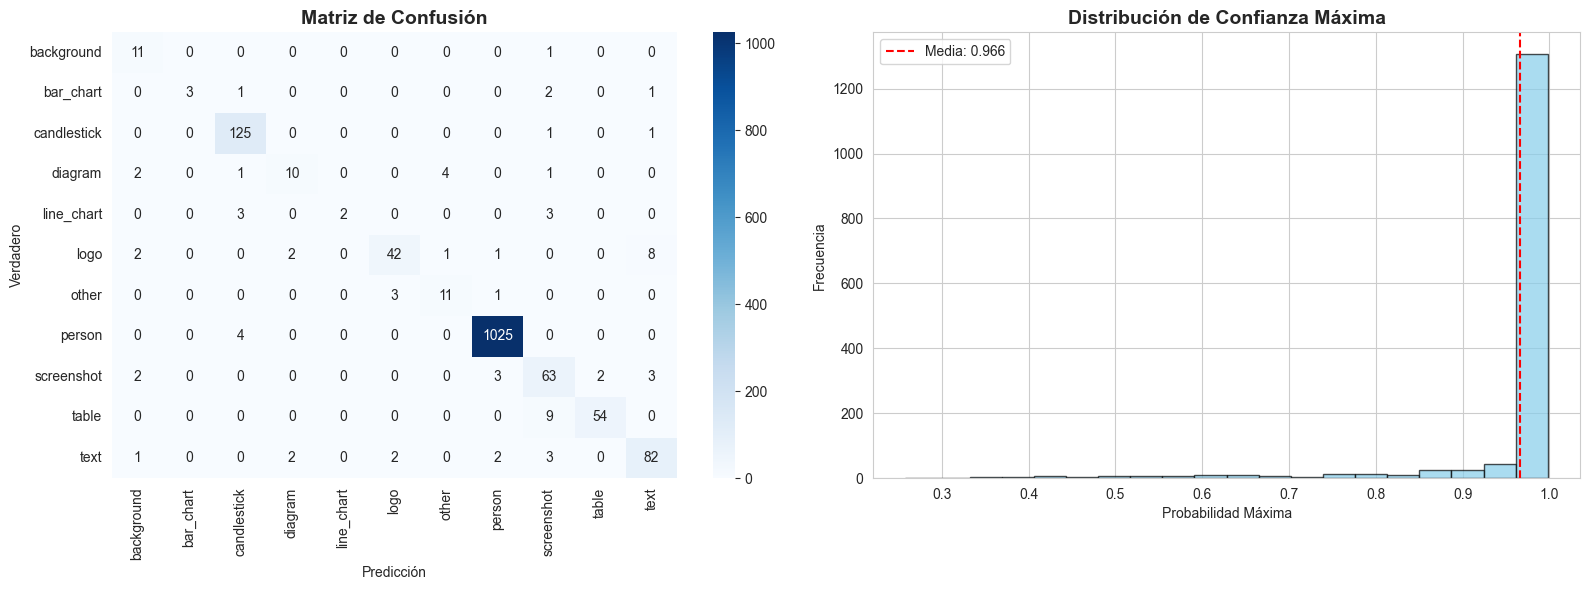

In [17]:
# Evaluar modelo en conjunto de test
print("📊 Evaluando modelo en conjunto de test...")

# Hacer predicciones
predictions = predictor.predict(test_df)
probabilities = predictor.predict_proba(test_df)

# Evaluar modelo
accuracy = predictor.evaluate(test_df, silent=True)

print(f"\n✅ Evaluación completada:")
print(f"   Accuracy: {accuracy}")

# Reporte de clasificación
print(f"\n📋 Reporte de Clasificación:")
report = classification_report(y_test, predictions, output_dict=True)

# Mostrar métricas por clase
for class_name, metrics in report.items():
    if isinstance(metrics, dict) and 'precision' in metrics:
        print(f"  {class_name:<20}: Precision={metrics['precision']:.3f}, "
              f"Recall={metrics['recall']:.3f}, F1={metrics['f1-score']:.3f}")

# Métricas generales
print(f"\n📈 Métricas Generales:")
print(f"  • Accuracy: {report['accuracy']:.4f}")
print(f"  • Macro Avg F1: {report['macro avg']['f1-score']:.4f}")
print(f"  • Weighted Avg F1: {report['weighted avg']['f1-score']:.4f}")

# Matriz de confusión
cm = confusion_matrix(y_test, predictions)

# Visualizaciones
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
axes[0].set_title('Matriz de Confusión', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicción')
axes[0].set_ylabel('Verdadero')

# Distribución de probabilidades máximas
max_probs = probabilities.max(axis=1)
axes[1].hist(max_probs, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[1].set_title('Distribución de Confianza Máxima', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Probabilidad Máxima')
axes[1].set_ylabel('Frecuencia')
axes[1].axvline(max_probs.mean(), color='red', linestyle='--', 
                label=f'Media: {max_probs.mean():.3f}')
axes[1].legend()

plt.tight_layout()
plt.show()


# 6. Unir modelo preentrenado (ResNet50) con cabeza de predicción entrenada


In [22]:
# Crear modelo completo: ResNet50 → embeddings → cabeza de predicción
print("🔄 Creando modelo completo (ResNet50 + cabeza de predicción)...")

# Cargar ResNet50 preentrenado (sin última capa)
resnet50 = models.resnet50(pretrained=True)
resnet50 = nn.Sequential(*list(resnet50.children())[:-1])  # Remover última capa
resnet50.eval()
resnet50.to(device)

print(f"✅ ResNet50 preentrenado cargado")
print(f"   Parámetros: {sum(p.numel() for p in resnet50.parameters()):,}")

# La cabeza de predicción ya está entrenada y guardada en './models/prediction_head_openai'
# Podemos usarla directamente para inferencias

print(f"\n✅ Modelo completo listo:")
print(f"   - ResNet50: Extrae embeddings (2048 dimensiones)")
print(f"   - Cabeza de predicción: Clasifica embeddings → clases")
print(f"   - Cabeza guardada en: './models/prediction_head_openai'")


🔄 Creando modelo completo (ResNet50 + cabeza de predicción)...
✅ ResNet50 preentrenado cargado
   Parámetros: 23,508,032

✅ Modelo completo listo:
   - ResNet50: Extrae embeddings (2048 dimensiones)
   - Cabeza de predicción: Clasifica embeddings → clases
   - Cabeza guardada en: './models/prediction_head_openai'


# 7. Probar inferencias con frames nuevos (no embeddings pregenerados)


In [26]:
# Función de inferencia que acepta imagen ya cargada
def predict_from_image(image, resnet50_model, predictor_model, device, transform=None):
    """
    Realiza inferencia desde una imagen ya cargada (PIL Image).
    
    Args:
        image: Imagen PIL ya cargada
        resnet50_model: Modelo ResNet50 preentrenado (sin última capa)
        predictor_model: Modelo de cabeza de predicción (AutoGluon)
        device: Dispositivo (cuda/cpu)
        transform: Transformaciones de imagen (si None, usa las estándar)
    
    Returns:
        predicción, probabilidades
    """
    if transform is None:
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
        ])
    
    # Preprocesar imagen
    try:
        image_tensor = transform(image).unsqueeze(0).to(device)
    except Exception as e:
        raise ValueError(f"Error preprocesando imagen: {e}")
    
    # Extraer embedding con ResNet50
    resnet50_model.eval()
    with torch.no_grad():
        embedding = resnet50_model(image_tensor)
        embedding = embedding.squeeze().cpu().numpy()
        # Aplanar si es necesario (ResNet50 devuelve (1, 2048, 1, 1) -> (2048,))
        if embedding.ndim > 1:
            embedding = embedding.flatten()
    
    # Crear DataFrame para AutoGluon
    feature_cols = [f'feature_{i}' for i in range(len(embedding))]
    embedding_df = pd.DataFrame([embedding], columns=feature_cols)
    
    # Predecir con cabeza de predicción
    prediction = predictor_model.predict(embedding_df)[0]
    probabilities = predictor_model.predict_proba(embedding_df)
    
    return prediction, probabilities



🧪 Probando inferencias con frames nuevos...
   Probando con 10 frames de test...


Inferencias: 100%|██████████| 10/10 [00:12<00:00,  1.25s/it]



📊 Resultados de inferencias:
   Frames procesados: 10
   Accuracy: 0.800

📋 Ejemplos de predicciones con imágenes:
   1. ✅ Pred: person               | True: person               | Conf: 0.807
   2. ✅ Pred: person               | True: person               | Conf: 0.795
   3. ✅ Pred: person               | True: person               | Conf: 0.837
   4. ❌ Pred: person               | True: table                | Conf: 0.858
   5. ❌ Pred: person               | True: screenshot           | Conf: 0.864
   6. ✅ Pred: person               | True: person               | Conf: 0.814
   7. ✅ Pred: person               | True: person               | Conf: 0.837
   8. ✅ Pred: person               | True: person               | Conf: 0.817
   9. ✅ Pred: person               | True: person               | Conf: 0.814
   10. ✅ Pred: person               | True: person               | Conf: 0.849


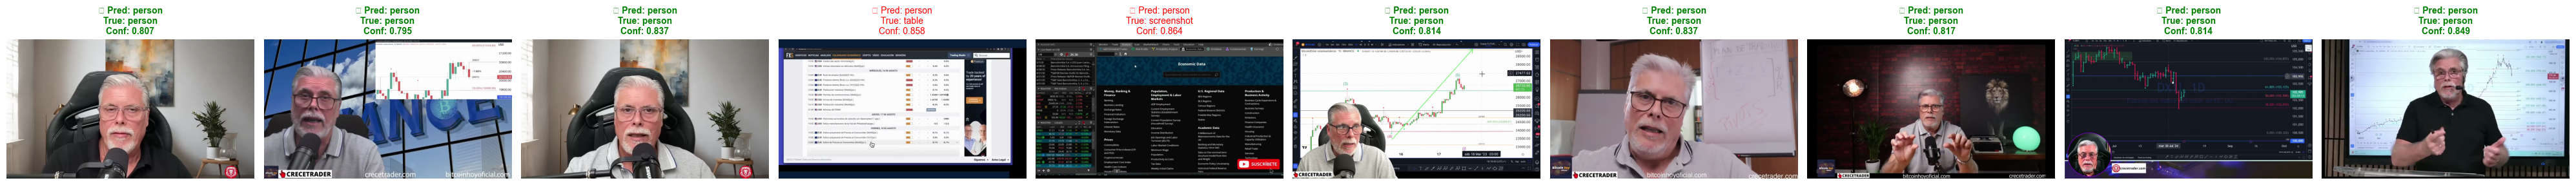

In [28]:
# Probar inferencias con frames de test
print("🧪 Probando inferencias con frames nuevos...")

# Seleccionar algunos frames de test para probar
n_test_samples = 10
test_samples = df_info.sample(
    n=min(n_test_samples, len(df_info)), 
    random_state=42
)

print(f"   Probando con {len(test_samples)} frames de test...")

# Realizar inferencias
predictions_new = []
probabilities_new = []
ground_truth = []
images_loaded = []

for idx, row in tqdm(test_samples.iterrows(), total=len(test_samples), desc="Inferencias"):
    try:
        frame_path = row['frame_path']
        true_label = row['openai_category_code']
        
        # Cargar imagen fuera de la función
        image = Image.open(frame_path).convert('RGB')
        images_loaded.append((image, frame_path))
        
        # Realizar inferencia con imagen ya cargada
        pred, probs = predict_from_image(
            image, 
            resnet50, 
            predictor, 
            device
        )
        
        predictions_new.append(pred)
        probabilities_new.append(probs)
        ground_truth.append(true_label)
    except Exception as e:
        print(f"⚠️  Error procesando {frame_path}: {e}")
        continue

# Comparar resultados
print(f"\n📊 Resultados de inferencias:")
print(f"   Frames procesados: {len(predictions_new)}")
if len(predictions_new) > 0:
    accuracy = sum(p == gt for p, gt in zip(predictions_new, ground_truth)) / len(predictions_new)
    print(f"   Accuracy: {accuracy:.3f}")

# Mostrar imágenes y predicciones
print(f"\n📋 Ejemplos de predicciones con imágenes:")
n_show = len(images_loaded)
fig, axes = plt.subplots(1, n_show, figsize=(4*n_show, 4))

if n_show == 1:
    axes = [axes]

for i in range(n_show):
    image, frame_path = images_loaded[i]
    pred = predictions_new[i]
    gt = ground_truth[i]
    max_prob = probabilities_new[i].max(axis=1).iloc[0]
    correct = "✅" if pred == gt else "❌"
    
    # Mostrar imagen
    axes[i].imshow(image)
    axes[i].axis('off')
    axes[i].set_title(
        f"{correct} Pred: {pred}\nTrue: {gt}\nConf: {max_prob:.3f}",
        fontsize=10,
        fontweight='bold' if pred == gt else 'normal',
        color='green' if pred == gt else 'red'
    )
    
    print(f"   {i+1}. {correct} Pred: {pred:<20} | True: {gt:<20} | Conf: {max_prob:.3f}")

plt.tight_layout()
plt.show()



# 8. Revisar discrepancias entre CLIP y OpenAI labels


In [29]:
# Encontrar registros donde clip_category_code != openai_category_code
print("🔍 Buscando discrepancias entre CLIP y OpenAI labels...")

# Filtrar registros con discrepancias
discrepancies = df_info[
    (df_info['clip_category_code'].notna()) & 
    (df_info['openai_category_code'].notna()) &
    (df_info['clip_category_code'] != df_info['openai_category_code'])
].copy()

print(f"   Total de discrepancias encontradas: {len(discrepancies):,}")

if len(discrepancies) > 0:
    # Mostrar distribución de discrepancias
    print(f"\n📊 Distribución de discrepancias:")
    discrepancy_pairs = discrepancies.groupby(['clip_category_code', 'openai_category_code']).size().sort_values(ascending=False)
    print(discrepancy_pairs.head(20))
    
    # Crear columna para etiqueta corregida
    discrepancies['corrected_category'] = None
    discrepancies['review_status'] = 'pending'  # pending, reviewed, needs_user_input
    
    print(f"\n✅ Dataset de discrepancias creado con {len(discrepancies)} registros")
else:
    print("✅ No se encontraron discrepancias entre CLIP y OpenAI labels")


🔍 Buscando discrepancias entre CLIP y OpenAI labels...
   Total de discrepancias encontradas: 7,340

📊 Distribución de discrepancias:
clip_category_code  openai_category_code
candlestick         person                  1184
text                person                  1015
bar_chart           person                   866
line_chart          person                   771
screenshot          person                   494
background          person                   455
other               person                   422
logo                text                     285
other               screenshot               196
diagram             person                   192
logo                person                   186
table               person                   134
other               table                    133
                    text                     100
background          logo                      85
diagram             text                      79
text                screenshot           